In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Đọc dữ liệu
data1 = pd.read_csv('heart.csv')   # Dữ liệu dạng chữ
data2 = pd.read_csv('heart2.csv')  # Dữ liệu dạng số

# 2. Định nghĩa từ điển ánh xạ (Mapping Dictionary) theo yêu cầu của bạn
# Tôi bổ sung thêm Sex: M=1, F=0 để khớp với chuẩn thường gặp trong heart2.csv
mapping_config = {
    'ChestPainType': {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3},
    'RestingECG':    {'Normal': 0, 'ST': 1, 'LVH': 2},
    'ExerciseAngina':{'Y': 1, 'N': 0},
    'ST_Slope':      {'Up': 0, 'Flat': 1, 'Down': 2},
    'Sex':           {'M': 1, 'F': 0}
}


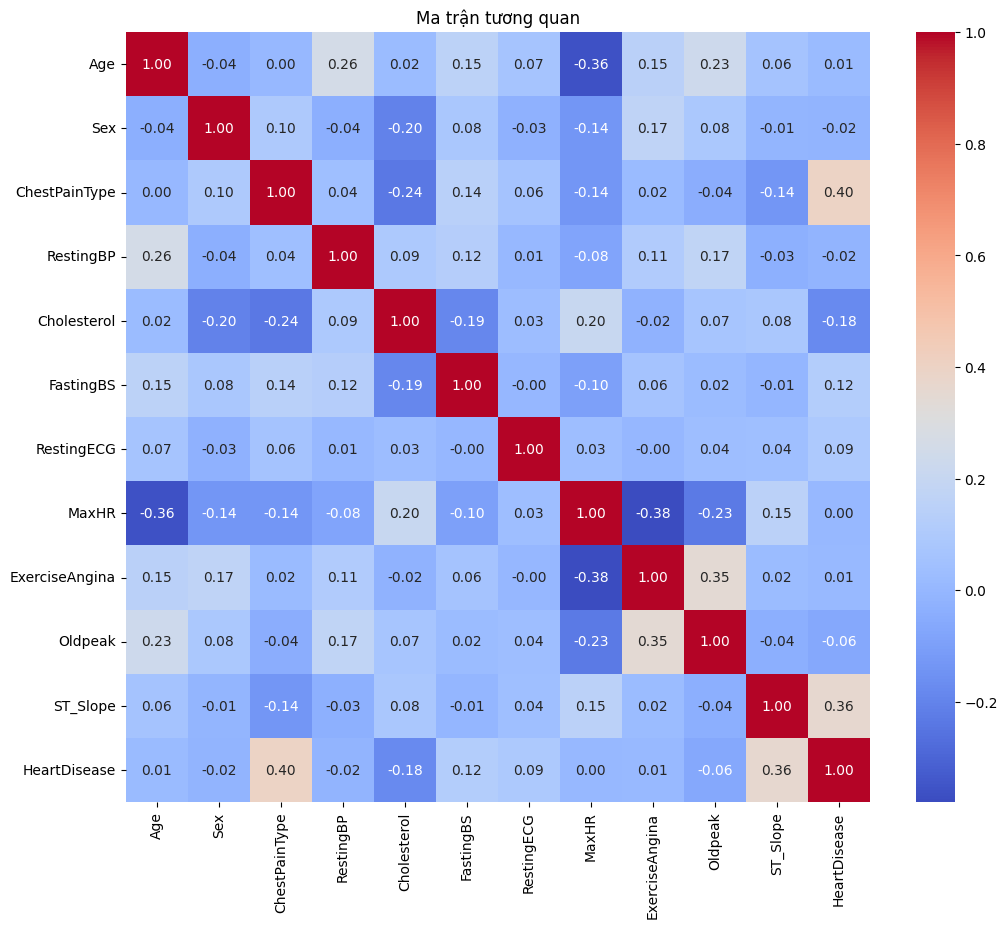

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,0,172,0,0.0,0,0
1,49,0,2,160,180,0,0,156,0,1.0,1,1
2,37,1,1,130,283,0,1,98,0,0.0,0,0
3,48,0,3,138,214,0,0,108,1,1.5,1,1
4,54,1,2,150,195,0,0,122,0,0.0,0,0


Kích thước dữ liệu sau khi gộp: (1943, 12)
Độ chính xác của mô hình: 78.92%

Báo cáo chi tiết:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       177
           1       0.80      0.82      0.81       212

    accuracy                           0.79       389
   macro avg       0.79      0.79      0.79       389
weighted avg       0.79      0.79      0.79       389



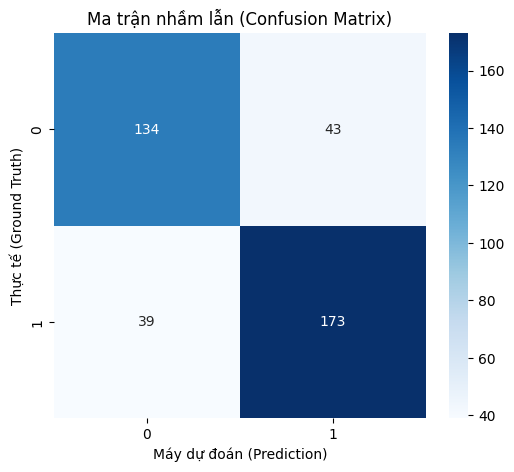

--- KẾT QUẢ VỚI NGƯỠNG 0.3 ---
              precision    recall  f1-score   support

           0       0.87      0.62      0.72       177
           1       0.74      0.92      0.82       212

    accuracy                           0.78       389
   macro avg       0.80      0.77      0.77       389
weighted avg       0.80      0.78      0.77       389



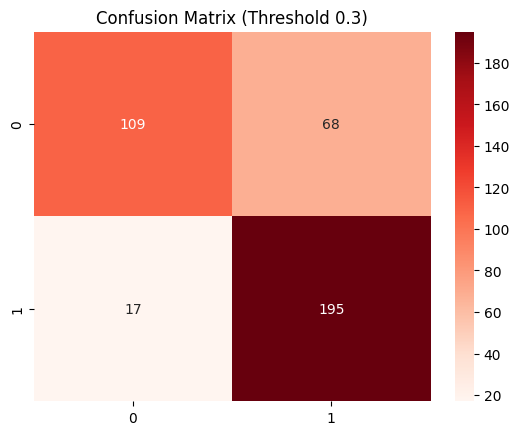

In [74]:

# 3. Tiền xử lý data1 (heart.csv) để biến chữ thành số
df1_clean = data1.copy()

for col, mapping in mapping_config.items():
    # Map dữ liệu theo từ điển, nếu có giá trị lạ không khớp thì sẽ ra NaN
    df1_clean[col] = df1_clean[col].map(mapping)

# Kiểm tra xem có dòng nào bị lỗi (NaN) do map không khớp không
if df1_clean.isnull().sum().sum() > 0:
    print("Cảnh báo: Có giá trị không khớp mapping trong data1. Đã điền 0 hoặc giá trị mặc định.")
    df1_clean = df1_clean.fillna(0) # Xử lý NaN nếu có

# 4. Gộp hai bộ dữ liệu lại thành một (Concatenate)
# Vì data2 đã là số chuẩn rồi, ta gộp trực tiếp
df_final = pd.concat([df1_clean, data2], ignore_index=True)
# Xem tương quan giữa các biến
plt.figure(figsize=(12, 10))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan")
plt.show()
display(df_final.head())

print(f"Kích thước dữ liệu sau khi gộp: {df_final.shape}")

# 5. Chuẩn bị dữ liệu cho Clustering
X = df_final.drop('HeartDisease', axis=1)
y = df_final['HeartDisease']

# 3. Chia tập Train/Test (Quan trọng: Máy học 80%, Thi 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scale dữ liệu (Fit trên Train, Transform trên Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Huấn luyện mô hình LOGISTIC REGRESSION
model = LogisticRegression()
model.fit(X_train_scaled, y_train) # Máy bắt đầu học w và b

# 6. Dự đoán và Đánh giá
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Độ chính xác của mô hình: {accuracy * 100:.2f}%")
print("\nBáo cáo chi tiết:")
print(classification_report(y_test, y_pred))

# 7. Vẽ Confusion Matrix (Thay vì vẽ Scatter plot lồng nhau)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.ylabel('Thực tế (Ground Truth)')
plt.xlabel('Máy dự đoán (Prediction)')
plt.show()

# Thay vì dùng: y_pred = model.predict(X_test_scaled) (Mặc định ngưỡng 0.5)

# 1. Lấy xác suất cụ thể (ví dụ: 0.72, 0.25...)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# 2. Tự đặt ngưỡng mới (ví dụ: 0.35)
new_threshold = 0.3
y_pred_new = (y_prob >= new_threshold).astype(int)

# 3. Đánh giá lại
print(f"--- KẾT QUẢ VỚI NGƯỠNG {new_threshold} ---")
print(classification_report(y_test, y_pred_new))

# Xem lại Ma trận nhầm lẫn
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds')
plt.title(f'Confusion Matrix (Threshold {new_threshold})')
plt.show()